# Convergence benchmark: Heavy top - polynomial approximation of degree $1 = j := \text{deg } q$

see thesis -> Numerical experiments -> Degree $j = 1$

In [1]:
import ngsolve
if ngsolve.__version__ < "6.2.2405-28": 
    raise Exception("NGSolve too old, pls run 'pip3 install --upgrade --pre ngsolve'")

In [2]:
from ngsolve import *
from netgen.occ import *
import ipywidgets as widgets
from ngsolve.comp import GlobalSpace
from ngsolve.webgui import Draw
from ngsolve.solvers import Newton
from ngsolve.comp import DifferentialSymbol
import numpy as np

## System parameter setup

In [3]:
mass = 15
Jxx = Jzz = 0.234375
Jyy = 0.468750
omega0 = CF( (0,150,-4.61538) )

In [4]:
b = sqrt(3/2 * Jyy/mass)
rho = mass/(4*b*b)     # kg/ m**2

In [5]:
center = Pnt( (0,1,0) )
disk = WorkPlane(Axes((0,1,0), Y)).RectangleC(2*b, 2*b).Face()
shape = Glue ([disk, Segment( (0,0,0), (0,1,0)) ])
shape.vertices.Min(Y).name="A"
mesh = Mesh(OCCGeometry(shape).GenerateMesh(maxh=3))
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

## Finite element space setup

In [6]:
# tangent space representation
RBshapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  y, -x, 0,
                  0, z, -y,
                  -z, 0, x) ).Reshape((6,3)).Compile()
RBspace = GlobalSpace (mesh, order=1, basis = RBshapes)

# basis of (equivalent to) symmetric matrices
SYMshapes = CF ( ( 1, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1,
                   0, 1, 0, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 0, 0, 0, 1, 0, 0,
                   0, 0, 0, 0, 0, 1, 0, 1, 0) ).Reshape((6,9)).Compile()
SYMspace = GlobalSpace (mesh, order=1, basis = SYMshapes)

# position space
P1shapes = CF ( ( 1, 0, 0,
                  0, 1, 0,
                  0, 0, 1,
                  x, 0, 0,
                  0, x, 0,
                  0, 0, x,
                  y, 0, 0,
                  0, y, 0,
                  0, 0, y,
                  z, 0, 0,
                  0, z, 0,
                  0, 0, z)).Reshape((12,3)).Compile() # realcompile=True, wait=True)
P1space = GlobalSpace (mesh, order=1, basis = P1shapes)
P1space.AddOperator("dx", VOL, P1shapes.Diff(x))
P1space.AddOperator("dy", VOL, P1shapes.Diff(y))
P1space.AddOperator("dz", VOL, P1shapes.Diff(z))

def MyGrad(gf):
    return CF( (gf.Operator("dx"), gf.Operator("dy"), gf.Operator("dz") )).Reshape((3,3)).trans
def MyGradB(gf):
    return CF( (gf.Operator("dx", BND), gf.Operator("dy", BND), gf.Operator("dz", BND))).Reshape((3,3)).trans
def MyGradBB(gf):
    return CF( (gf.Operator("dx", BBBND), gf.Operator("dy", BBBND), gf.Operator("dz", BBBND))).Reshape((3,3)).trans
              

In [7]:
fesR = NumberSpace(mesh)

fes = P1space * RBspace * fesR**3 * fesR**3
festest = RBspace * RBspace * SYMspace * fesR**3 * fesR**3

gfold = GridFunction(fes)
gf = GridFunction(fes)

# compared to notation from thesis:
# q - initial position, phatold - initial momentum, (fa1old - unused), (fa2old - unused)
qold, phatold, fa1old, fa2old = gfold.components
gfq, gfphat, gffa1, gffa2 = gf.components

# compared to notation from thesis:
# q - new position, phat - new momentum, fa1 - lagrange parameter mu, fa2 - lagrange parameter lambda
q, phat, fa1, fa2  = fes.TrialFunction()
dq1, dq2, dlagsym, da, daprime = festest.TestFunction()

dvert = DifferentialSymbol(BBBND)

## The equations

In [8]:
force = CF( (0,0,-9.81*rho) )
dpointA = da
dpointAprime = daprime

P0 = CF( (0, 0, 0) )
PA0 = CF( (0, 1, 0)) 


def setup_eqsys(tau: float) -> BilinearForm:    
    
    qold.Set ( (x, y, z) )

    # rotational part of q at different points in time
    Rnew = MyGrad(q)
    Rold = MyGradB(qold)
    Rmean = 0.5*(Rold+Rnew)

    v = (q - qold)/tau
    
    a = BilinearForm(trialspace=fes, testspace=festest)


    # What follows are the time stepper equations in the same general order as in the thesis.
    
    a += (((Rnew*phat-rho*v) - tau/2*force) * (Rnew*dq1)).Compile(realcompile=True, wait=True) * ds
    a += (((rho*v-Rold*phatold) - tau/2*force) * (Rold*dq2)).Compile(realcompile=True, wait=True) * ds
    # forces from Lagrange parameters, in t_n and t_{n+t}:
    a += ( (- tau/2*fa1 ) * (Rnew*dq1)).Compile(realcompile=True, wait=True) *dvert("A")
    a += ( (- tau/2*fa2 ) * (MyGradBB(qold)*dq2)).Compile(realcompile=True, wait=True) *dvert("A")
    
    # constraints and velocity constraints:
    a += ((q-P0)*dpointA).Compile(realcompile=True, wait=True) * dvert("A")
    a += ((phat)*dpointAprime).Compile(realcompile=True, wait=True) * dvert("A")
    
    # rotational part of q is orthogonal:
    a += InnerProduct (Rnew.trans*Rnew-Id(3), dlagsym).Compile(realcompile=True, wait=True) * ds 

    return a

In [9]:
def init_values():
    # tricky to set initial conditions, since mass matrix alone is singular 
    gf.vec[:] = 0
    gfphat.Set ( rho*Cross (omega0, CF((x,y,z))) , definedon=mesh.Boundaries(".*") )
    
    qs,dqs = P1space.TnT()
    bfset = BilinearForm(qs*dqs*ds + qs.Operator("dy")*dqs.Operator("dy")*ds).Assemble()
    lfset = LinearForm(CF((x,y,z))*dqs*ds + CF((0,1,0))*dqs.Operator("dy")*ds).Assemble()
    gfq.vec[:] = bfset.mat.Inverse()*lfset.vec

In [10]:
scene = Draw (gf.components[1], mesh, deformation=(gf.components[0]-CF((x,y,z))), center=(0,0,0), radius=1.2)

tw = widgets.Text(value='t = 0')
display(tw)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

Text(value='t = 0')

In [11]:
end_pos = []
taus = [0.004 * 2**(1-n) for n in range(1, 9)]
for tau in taus:
    print(tau)
    a = setup_eqsys(tau)
    init_values()
    t = 0
    while t < 1-1e-10:
        gfold.vec[:] = gf.vec
        Newton(a=a, u=gf, printing=False, maxerr=1e-8)
        scene.Redraw()
        t += tau
        tw.value = "t = {t:.2f}".format(t=t)
        
    end_pos.append(np.array([Integrate(gfq[i]*ds, mesh)/(4*b**2) for i in range(3)]))

print(end_pos)

0.004
0.002
0.001
0.0005
0.00025
0.000125
6.25e-05
3.125e-05
[array([ 0.17592345,  0.62805988, -0.75801829]), array([ 0.17396077,  0.63733718, -0.75069233]), array([ 0.17349672,  0.63941381, -0.74903196]), array([ 0.17338207,  0.63992068, -0.74862553]), array([ 0.17335348,  0.64004666, -0.74852444]), array([ 0.17334634,  0.64007811, -0.7484992 ]), array([ 0.17334456,  0.64008597, -0.74849289]), array([ 0.17334411,  0.64008794, -0.74849132])]


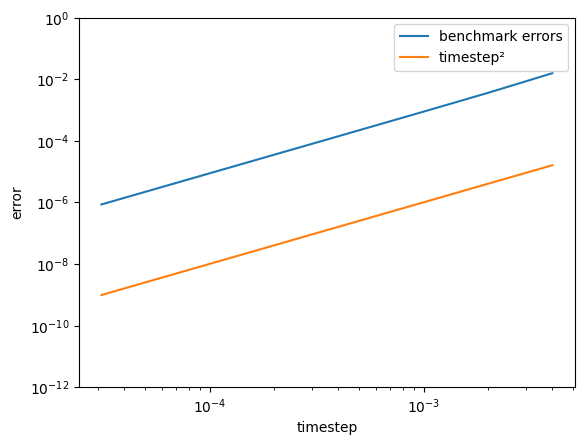

In [12]:
import matplotlib.pyplot as plt
import pickle

# end pos at tau = 0.001*2**(1-10), calculated with a high time step
ref_val = pickle.loads(b'\x80\x04\x95\xa4\x00\x00\x00\x00\x00\x00\x00]\x94\x8c\x16numpy._core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x03\x85\x94h\x04\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C\x18*\x97a\x90"0\xc6?\x10e/\x12\x9b{\xe4?5\xf3\xa8\xf5\xa2\xf3\xe7\xbf\x94t\x94ba.')

end_errs = []
for e in end_pos:
    end_err = np.linalg.norm(ref_val - e, 2)
    end_errs.append(end_err)

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-12, 1)
plt.plot(taus, end_errs, label="benchmark errors")
plt.plot(taus, [tau**2 for tau in taus], label="timestep²")
plt.legend()
plt.xlabel("timestep")
plt.ylabel("error")
plt.show()